In [1]:
#!pip install mediapipe
!pip install mediapipe -i https://pypi.tuna.tsinghua.edu.cn/simple
!pip install scikit-learn

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [2]:
# Unzip the dataset
!unzip -q handgesturefinal.zip -d /content/

In [3]:
import os
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle
from torch.utils.data import Dataset # 仍需繼承 Dataset
from torchvision import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import joblib

--- Stage 1: Starting to process images and generate skeleton data ---
Scanning and extracting skeletons from /content/train...
Scan complete. Successfully detected skeletons: 1387, Failed detections: 269



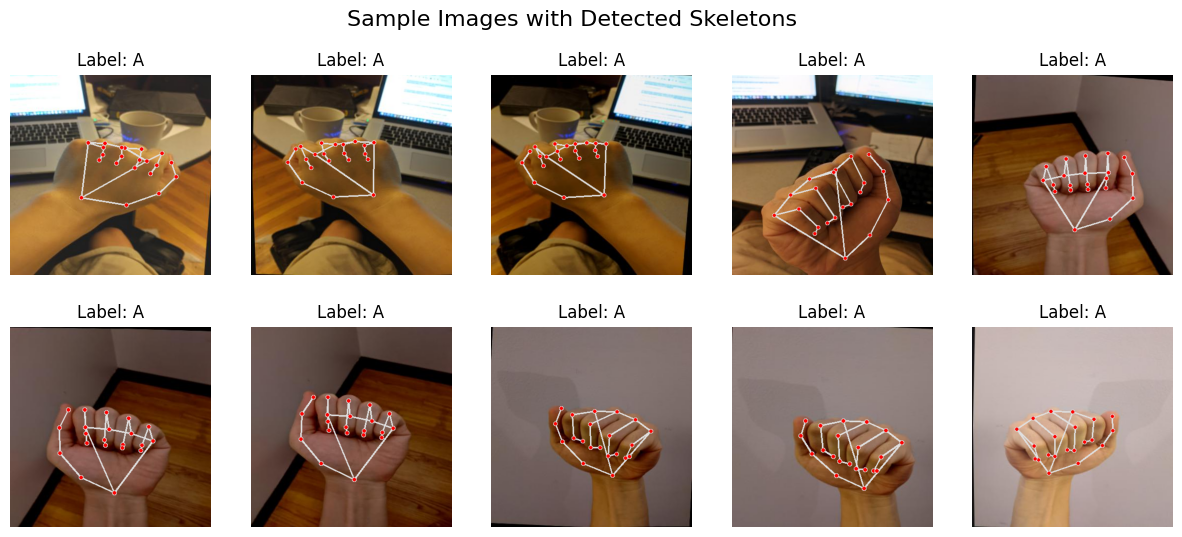

In [5]:
# ==============================================================================
# Stage 1: Extract Skeleton Data (mostly same as the previous version)
# ==============================================================================
print("--- Stage 1: Starting to process images and generate skeleton data ---")

class HandLandmarkExtractor(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.landmark_data = []
        self.labels = []
        self.processed_images_for_display = []
        self.labels_for_display = []

        mp_hands = mp.solutions.hands
        self.mp_drawing = mp.solutions.drawing_utils
        self.hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.3)

        self._prepare_dataset()

    def _prepare_dataset(self):
        success_count = 0
        failure_count = 0

        temp_dataset = datasets.ImageFolder(self.data_dir)
        self.class_to_idx = temp_dataset.class_to_idx
        self.classes = temp_dataset.classes

        print(f"Scanning and extracting skeletons from {self.data_dir}...")
        for path, label_idx in temp_dataset.samples:
            img = cv2.imread(path)
            if img is None:
                failure_count += 1
                continue

            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            results = self.hands.process(img_rgb)

            if results.multi_hand_landmarks:
                success_count += 1
                hand_landmarks = results.multi_hand_landmarks[0]

                data_aux = []
                for landmark in hand_landmarks.landmark:
                    data_aux.extend([landmark.x, landmark.y])

                self.landmark_data.append(data_aux)
                self.labels.append(label_idx) # Directly use the numeric label

                # Store a few images with skeletons for display
                if len(self.processed_images_for_display) < 10:
                    image_to_draw = img.copy()
                    self.mp_drawing.draw_landmarks(image_to_draw, hand_landmarks, mp.solutions.hands.HAND_CONNECTIONS)
                    self.processed_images_for_display.append(image_to_draw)
                    self.labels_for_display.append(self.classes[label_idx])
            else:
                failure_count += 1

        print(f"Scan complete. Successfully detected skeletons: {success_count}, Failed detections: {failure_count}\n")

    def get_data_for_sklearn(self):
        """Provides NumPy arrays for use with scikit-learn."""
        return np.array(self.landmark_data), np.array(self.labels)

# --- Set up paths and extract data ---
data_dir = '/content'
train_dir = os.path.join(data_dir, 'train')

if not os.path.isdir(train_dir):
    raise FileNotFoundError(f"Error: Training directory '{train_dir}' not found. Please check the path.")

# Instantiate the class and extract data
feature_extractor = HandLandmarkExtractor(train_dir)
X, y = feature_extractor.get_data_for_sklearn()

# Display sample images with successfully detected skeletons
if feature_extractor.processed_images_for_display:
    plt.figure(figsize=(15, 6))
    plt.suptitle("Sample Images with Detected Skeletons", fontsize=16)
    for i, img in enumerate(feature_extractor.processed_images_for_display):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"Label: {feature_extractor.labels_for_display[i]}")
        plt.axis('off')
    plt.show()


--- Stage 2: Starting to train a Random Forest model with scikit-learn ---
Feature data (X) shape: (1387, 42)
Training set size: 1109
Test set size: 278

Training the Random Forest model...
Model training complete!


Model successfully saved to: random_forest_hand_model.joblib
--- Model Evaluation ---
Model accuracy on the test set: 80.94%

Classification Report:
              precision    recall  f1-score   support

           A       0.81      0.93      0.87        14
           B       0.82      1.00      0.90         9
           C       1.00      0.86      0.92         7
           D       0.86      0.60      0.71        10
           E       0.79      1.00      0.88        11
           F       1.00      1.00      1.00        12
           G       0.70      0.70      0.70        10
           H       0.86      0.67      0.75         9
           I       0.82      1.00      0.90        14
           J       0.80      0.53      0.64        15
           K       0.90      0.90     

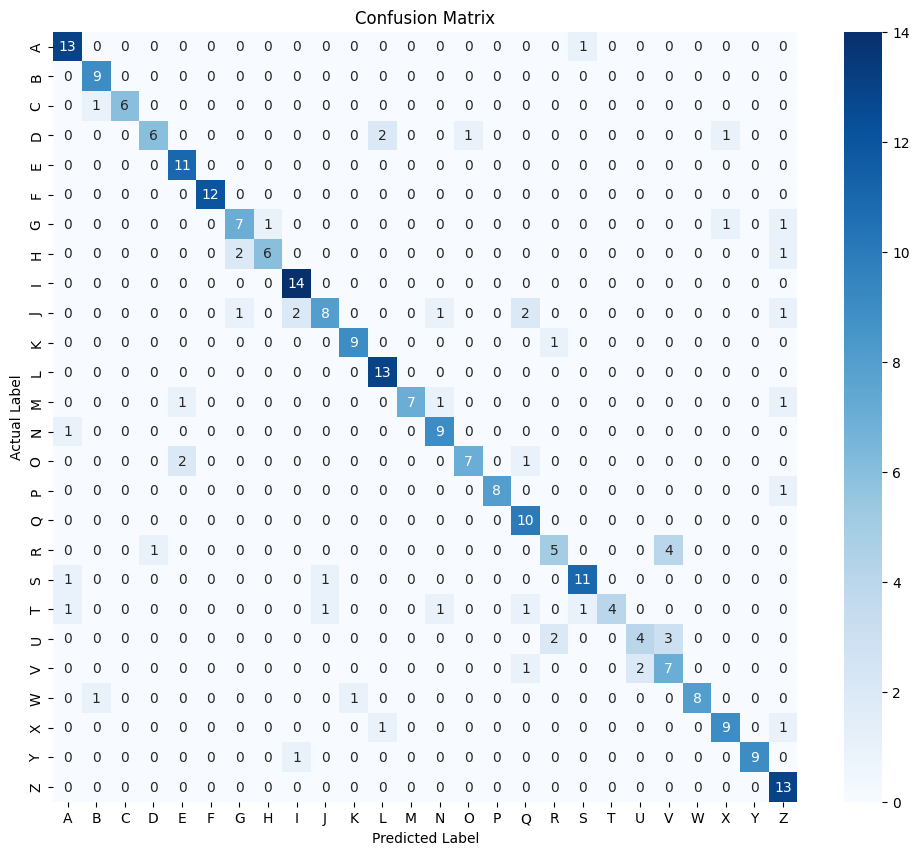

In [6]:

# ==============================================================================
# Stage 2: Train a Random Forest Model using scikit-learn
# ==============================================================================
print("\n--- Stage 2: Starting to train a Random Forest model with scikit-learn ---")

if len(X) == 0:
    print("No available data to train the model. Terminating the program.")
else:
    # --- 1. Split the data into training and testing sets ---
    # Split all data using an 80/20 ratio
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y)

    print(f"Feature data (X) shape: {X.shape}")
    print(f"Training set size: {X_train.shape[0]}")
    print(f"Test set size: {X_test.shape[0]}\n")

    # --- 2. Create and train the Random Forest Classifier ---
    print("Training the Random Forest model...")
    # n_estimators is the number of trees in the forest, a key hyperparameter.
    # class_weight='balanced' automatically handles class imbalance issues.
    model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
    model.fit(X_train, y_train)
    print("Model training complete!\n")

    # 1. Define the filename for the saved model
    model_filename = 'random_forest_hand_model.joblib'

    # 2. Save the model using joblib.dump
    joblib.dump(model, model_filename)

    print(f"\nModel successfully saved to: {model_filename}")

    # --- 3. Make predictions on the test set and evaluate ---
    print("--- Model Evaluation ---")
    y_pred = model.predict(X_test)

    # Calculate and print the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model accuracy on the test set: {accuracy * 100:.2f}%\n")

    # Print a detailed classification report (including Precision, Recall, F1-score)
    # target_names needs to be a list of strings
    class_names = feature_extractor.classes
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # --- 4. Visualize the Confusion Matrix ---
    print("Plotting the confusion matrix...")
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

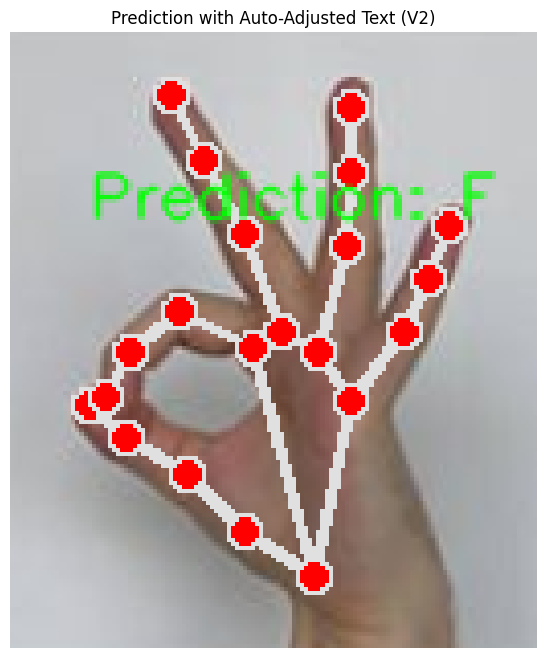

In [8]:
# --- 1. Helper Function: Create Label-to-Index Mapping ---
# To convert the model's predicted numbers (0, 1, 2...) back to class names ('A', 'B', 'C'...)
def get_label_mapping(data_dir):
    """Scans a directory and creates a dictionary mapping an index to a class name."""
    class_names = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
    idx_to_label = {i: label for i, label in enumerate(class_names)}
    return idx_to_label

def predict_and_visualize(model_path, image_path, idx_to_label_map):
    """
    Loads the model, performs skeleton detection and prediction on a new image,
    and visualizes the result with dynamically adjusted text position and size.
    (V2: Adjusted font size formula)
    """
    try:
        model = joblib.load(model_path)
    except FileNotFoundError:
        print(f"Error: Model file not found at '{model_path}'.")
        return

    # Lowering the confidence threshold is recommended to improve the detection rate
    mp_hands = mp.solutions.hands
    mp_drawing = mp.solutions.drawing_utils
    hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.2) #<-- Recommended to lower from 0.3 to 0.2

    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not read the image at '{image_path}'.")
        return

    image_to_draw = img.copy()
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = hands.process(img_rgb)

    prediction_text = "No Hand Detected"

    if results.multi_hand_landmarks:
        hand_landmarks = results.multi_hand_landmarks[0]

        # --- Extract coordinates for prediction ---
        data_aux = []
        h, w, _ = image_to_draw.shape
        x_coords_px = [int(landmark.x * w) for landmark in hand_landmarks.landmark]
        y_coords_px = [int(landmark.y * h) for landmark in hand_landmarks.landmark]

        for landmark in hand_landmarks.landmark:
            data_aux.extend([landmark.x, landmark.y])

        landmarks_for_prediction = np.array(data_aux).reshape(1, -1)
        prediction_idx = model.predict(landmarks_for_prediction)[0]
        predicted_class = idx_to_label_map.get(prediction_idx, "Unknown")
        prediction_text = f"Prediction: {predicted_class}"

        # --- Draw skeleton ---
        mp_drawing.draw_landmarks(image_to_draw, hand_landmarks, mp_hands.HAND_CONNECTIONS)

        # --- (Adjustment) Dynamically calculate text position and size ---
        x_min, x_max = min(x_coords_px), max(x_coords_px)
        y_min, _ = min(y_coords_px), max(y_coords_px)

        text_x = x_min
        text_y = y_min - 15 if y_min > 20 else y_min + 30

        # --- Main adjustment is here ---
        # 1. Increase the denominator (e.g., from 200 -> 300) to make the base font smaller.
        # 2. Decrease the multiplier (e.g., from 1.2 -> 1.0).
        font_scale = max(0.5, (x_max - x_min) / 300.0 * 1.0)
        font_thickness = max(1, int(font_scale * 2))

        # Write the prediction text at the dynamically calculated position (using green)
        cv2.putText(image_to_draw, prediction_text, (text_x, text_y),
                    cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 255, 0), font_thickness, cv2.LINE_AA)

    else: # If no hand is detected
        # Display a red notification text in the top-left corner with a fixed font size of 1
        cv2.putText(image_to_draw, prediction_text, (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

    # --- Display the result ---
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(image_to_draw, cv2.COLOR_BGR2RGB))
    plt.title("Prediction with Auto-Adjusted Text (V2)")
    plt.axis('off')
    plt.show()


model_filename = 'random_forest_hand_model.joblib'
train_dir = '/content/train'
new_image_path = '/content/F.png' # <--- Change to your own image path

try:
    idx_to_label = get_label_mapping(train_dir)
    predict_and_visualize(model_filename, new_image_path, idx_to_label)
except Exception as e:
    print(f"An error occurred: {e}")